# **Classify Real and AI-Generated Synthetic Images**

by Amin Nazemzadeh, Chibueze Nwade, and Sean Fitzgerald

#Introduction

In recent years image-creating AI technology has advanced rapidly. With DALL-E 2, midjourny, Dreamstudio, and more fake image AI models approximately 2 million AI generated images are created each day. This is incredible technology that can be used for a variety of interesting and helpful tasks. However, there are many dangers to AI generated images. 

Scams, misinformation, propaganda, plagiarism and identity theft are all common over the internet, and can be propelled forward with the use of image-faking AI. Being able to distinguish between real and fake images will help combat the negative uses of this technology. Our project is designed to differentiate between real and fake images, using a Convolutional Neural Network trained on a dataset of real and AI generated images. 

#The Dataset

We are using the CIFAKE: Real and AI-Generated Synthetic Images dataset found on kaggle [here](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images). The database contains 60,000 real images collected from the CIFAR-10 database, and 60,000 fake images created from Stable Diffusion version 1.4. All images, real and fake, are resolution 32x32. So while these images are not the resolution of images we normally encounter, they provide enough information to begin tackling the issue.

In [1]:
# %pip install tensorflow
# %pip install pandas
# %pip install numpy
# %pip install requests
# %pip install beautifulsoup4
import pandas
import numpy
import requests
from bs4 import BeautifulSoup
import tensorflow
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Data Wrangling

The data coming in was split into 2 folders, 1 for training and 1 for testing. Within each folder, there were two classes each image was associated with: FAKE and REAL. The dataset being organized on import is incredibly useful and made the data wrangling not a problem. Below we have displayed a portion of the training set. With the human eye there is no clear distinction between the real and fake images. This further proves the need for computer assistance in identifying fake images. 

In [2]:
from zipfile import ZipFile
file_name = './archive (2).zip'

with ZipFile(file_name, 'r') as zip_file:
  zip_file.extractall()
  print('Done')

Done


In [3]:
path_to_training_directories = './archive/train'
path_to_test_images = './archive/test'
batch_size = 32
img_height = 32
img_width = 32

train_ds = tensorflow.keras.utils.image_dataset_from_directory(
  path_to_training_directories,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tensorflow.keras.utils.image_dataset_from_directory(
  path_to_test_images,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = train_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


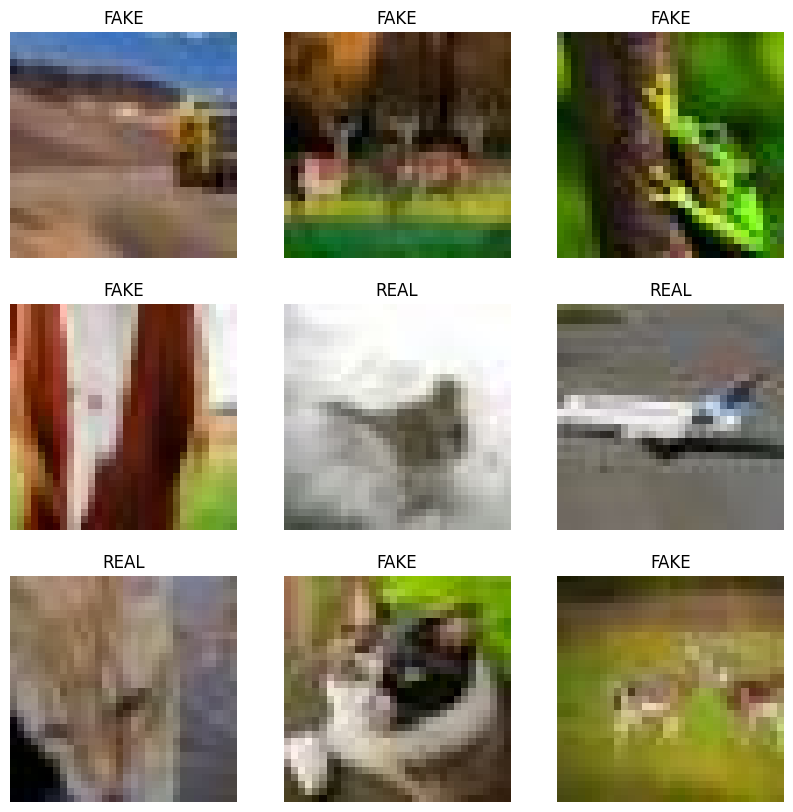

In [4]:
# lets test tensorflow tutorial first
# these are the first 9 images from training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Training

We are using the tesnorflow module to create our Convoltion Neural Network

In [5]:
# these are here to boost performance
# .cache keeps the images in memory after they're loaded off disk during the first epoch
# prefetch overlaps data preprocessing and model execution while training
AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
# RGB values are in the range of 0-255, we'll make it into range of 0-1
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [7]:
# now we create the model
# we have 3 convolution blocks, activation function in relu
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          1

In [8]:
epochs=3 # change to 10 or a big number for grapghs to work
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
3125/3125 [==============================] - 160s 49ms/step - loss: 0.2650 - accuracy: 0.8881 - val_loss: 0.1973 - val_accuracy: 0.9211
Epoch 2/3
3125/3125 [==============================] - 133s 43ms/step - loss: 0.1815 - accuracy: 0.9283 - val_loss: 0.1748 - val_accuracy: 0.9312
Epoch 3/3
3125/3125 [==============================] - 137s 44ms/step - loss: 0.1580 - accuracy: 0.9379 - val_loss: 0.1653 - val_accuracy: 0.9353


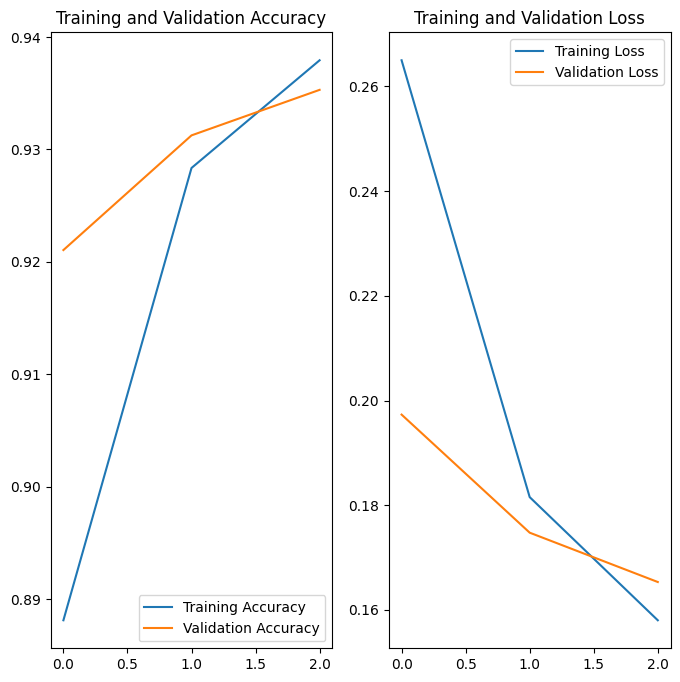

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

initial_model = model
# we see overfitting

Our first go has gotten great results! The accuracy after 3 epoch is ~94% and the training and test data converge to a very similar value! The loss of the train and test data also converge to a near identical value. There are no signs of over or under fitting so 3 epochs looks to be a good threshold. However, just for testing purposes we will try increasing the epochs and trying different activation functions.

Epoch 1/4
3125/3125 [==============================] - 177s 57ms/step - loss: 0.1447 - accuracy: 0.9437 - val_loss: 0.1550 - val_accuracy: 0.9374
Epoch 2/4
3125/3125 [==============================] - 176s 56ms/step - loss: 0.1290 - accuracy: 0.9500 - val_loss: 0.1509 - val_accuracy: 0.9430
Epoch 3/4
3125/3125 [==============================] - 142s 45ms/step - loss: 0.1172 - accuracy: 0.9552 - val_loss: 0.1569 - val_accuracy: 0.9413
Epoch 4/4
3125/3125 [==============================] - 146s 47ms/step - loss: 0.1050 - accuracy: 0.9596 - val_loss: 0.1700 - val_accuracy: 0.9354


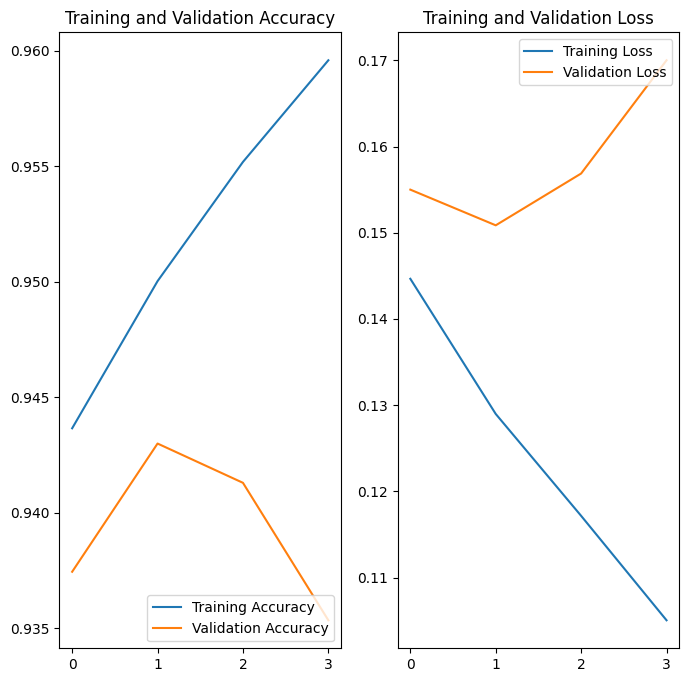

In [ ]:
epochs=4 # change to 10 or a big number for grapghs to work
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



Increasing the epoch to 4 resulted as we expected, the training accuracy stayed relatively the same but the test accuracy took a dive. This further enforces 3 epochs as the correct number. The graph above shows massive overfitting and very high loss for the test data. So we know the correct epochs, next we will try another activation function. The function we will try is sigmoid, as the output layer is binary fake or real. 

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)         

Epoch 1/3
3125/3125 [==============================] - 151s 48ms/step - loss: 0.6458 - accuracy: 0.6024 - val_loss: 0.5359 - val_accuracy: 0.7307
Epoch 2/3
3125/3125 [==============================] - 152s 49ms/step - loss: 0.4336 - accuracy: 0.7963 - val_loss: 0.3740 - val_accuracy: 0.8311
Epoch 3/3
3125/3125 [==============================] - 150s 48ms/step - loss: 0.3418 - accuracy: 0.8504 - val_loss: 0.3194 - val_accuracy: 0.8642


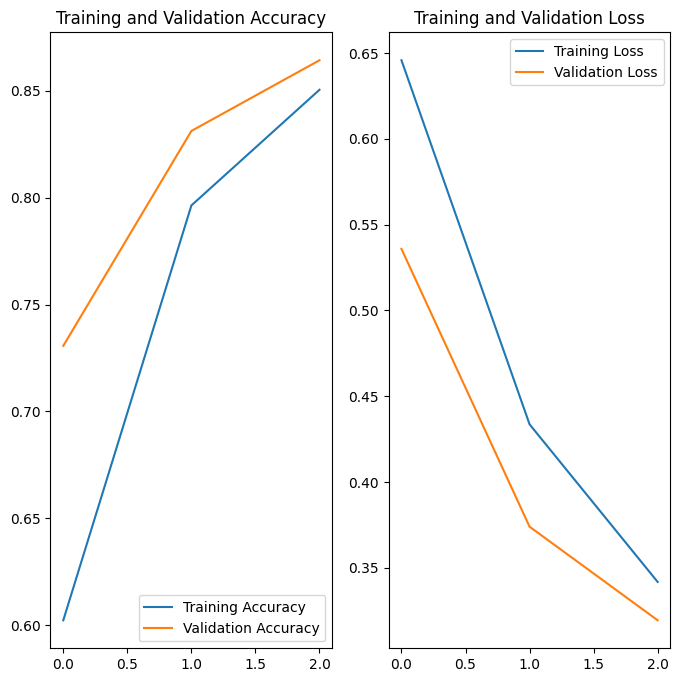

In [ ]:
epochs=3 # change to 10 or a big number for grapghs to work
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As shown above, the change in activation functions was not successful. The results are not terrible with a ~84% accuracy rate on the training data. However in comparison with the upwards of 95% from the Relu function the victor is clear. The graphs above also show the test data having high accuracy than the train data, an indication that the model is underfitting. This is most likely caused by sigmoid being a nonoptimal activation function for the data.


# Creating a Generative Adversarial Network
At this section of the tutorial, we are going to be creating a Generative Adversarial Network, or GAN for short. A GAN is a network that abides by an adversarial process to generate some form data, which in most cases are images. The adversarial process involves having a generator whose task is to learn to create images (or other data depending on the requirements of the project) that look real so that it can attempt to ‘outsmart’ the discriminator whose task is to learn to determine if an image is real or not.
In the context of our project, we plan to use a GAN to generate images to further test the CNN that we created in the previous section. We chose this approach because it appropriately illustrates how our CNN would be used in a real-world setting, especially when people are using it to classify AI images that have been created in real-time.


##The Dataset
The first part of the process is to import our dataset. The dataset that we would use to train our GAN is the [CIFAR-10 Python](https://www.kaggle.com/datasets/pankrzysiu/cifar10-python) dataset which contains over 60000 color images and 10 different classes which each class having 6000 images. The class that we would be training our GAN on is the cat class and so our aim would be for our GAN to generate cat images.

In [19]:
#importing relevant libraries
import tensorflow
import time
from IPython.display import clear_output
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from IPython import display
import requests
import pandas
import numpy as np
import requests
from bs4 import BeautifulSoup
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD
import sys
import os
import tensorflow

Firstly, we will unzip the dataset compressed file and then we would store its contents in the input folder. Afterwards, we would store the dataset in the X_train variable which would serve as our reference to the dataset.

In [11]:
#unzipping data file
from zipfile import ZipFile
file_name = './archive (3).zip'

with ZipFile(file_name, 'r') as zipf:
  zipf.extractall()
  print('Done')

Done


In [12]:
#importing the data from the unzipped file
from os import listdir, makedirs, rmdir
from os.path import join, exists, expanduser
import shutil

cache_dir = expanduser(join('~', '.keras'))
if exists(cache_dir):
    shutil.rmtree(cache_dir)
if not exists(cache_dir):
    makedirs(cache_dir)
datasets_dir = join(cache_dir, 'datasets') # /cifar-10-batches-py
if exists(datasets_dir):
    shutil.rmtree(datasets_dir)
if not exists(datasets_dir):
    makedirs(datasets_dir)


!cp ./input/cifar-10-python.tar.gz ~/.keras/datasets/
!ln -s  ~/.keras/datasets/cifar-10-python.tar.gz ~/.keras/datasets/cifar-10-batches-py.tar.gz
!tar xzvf ~/.keras/datasets/cifar-10-python.tar.gz -C ~/.keras/datasets/

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [13]:
# Load CIFAR10 data: using only the cat images
(X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
X_train = X_train[y_train.flatten() == 3]

Here are some of the images that we would be working with. As you can see, the resolution of the images is quite low as result of being 32 x 32 and so this could affect the kind of images generated by our GAN. 

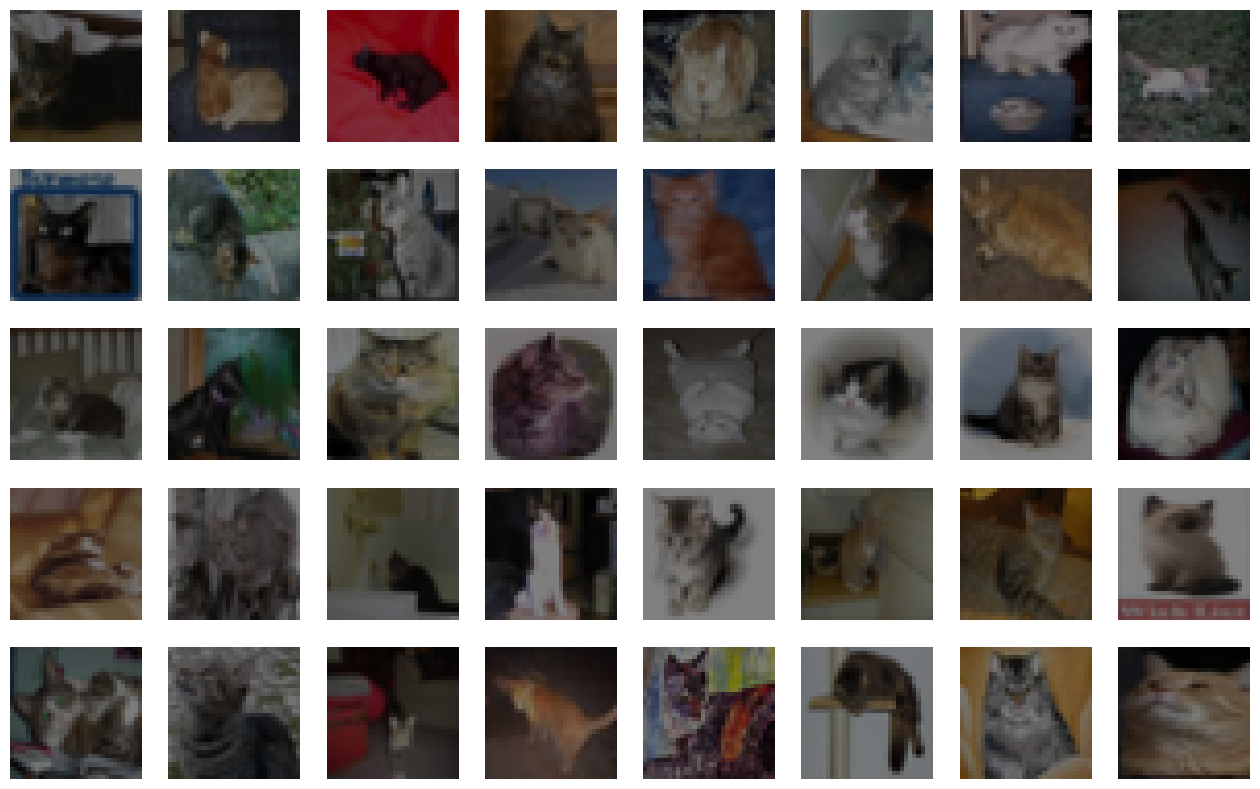

In [14]:
#display images
s=X_train[:40]
s = 0.5 * s + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, img in enumerate(s):
        ax[i//8, i%8].imshow((img).astype(np.uint8))
        ax[i//8, i%8].axis('off')
        
plt.show()

At this stage, we are defining the attributes of the images that we would be using to train the GAN and we are also defining a crucial aspect of the structure of the GAN, and that is the latent dimension. The latest dimension (also called latent space) itself has no meaning but it serves as a hypersphere with each variable within it being drawn from a Gaussian distribution with a mean of zero and a standard deviation of one. It plays a significant role in the training of the GAN because the GAN is able to learn how to map points from the latent space to specific output images. This explanation should be suitable enough to understand what is happening with our GAN, but for a more thorough explanation, you can find more information about the latent dimension [here](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/).

In [15]:
# Input shape
img_rows = 32
img_cols = 32
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100

After defining the qualities of our images, the next step in the process is to normalize our data. This is done so that we can improve the efficiency of the learning process since normalizing the images can speed up our model’s learning. Additionally, we also shuffle our data size and determine its batch size which both affect the efficiency of our model as well.

In [16]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3).astype('float32')
X_train = (X_train - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [17]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [20]:
# Batch and shuffle the data
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##Defining the Model


At this juncture, we will define the architecture of our GAN. The first aspect of the GAN that we will be defining is the Generator. The generator has a similar architecture to a typical CNN but the one important aspect of our generator that is not found in some CNN models, is the Upsampling layer. The Upsampling layer is used to double the dimensions of the input so that we can undo any downsampling that has been done by the convolutional layers. This also allows to essentially recover our original input and create an image that is as close to images from the distribution of the input image, as possible.

In [21]:
from keras.engine.training import model_serialization
#function for building the generator
def create_generator():
    model = Sequential([
        Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim),\
        BatchNormalization(), 
        LeakyReLU(),
        Reshape((8, 8, 128)),

        UpSampling2D(), #upsamples to 16*16*128

        Conv2D(128, kernel_size=3, padding="same"),
        BatchNormalization(momentum=0.8),
        Activation("relu"),

        UpSampling2D(), #upsamples to 32*32*128

        Conv2D(64, kernel_size=3, padding="same"),
        BatchNormalization(momentum=0.8),
        Activation("relu"),

        Conv2D(channels, kernel_size=3, padding="same"),
        Activation("tanh"),
      ])

    #outputs an image of 32*32*3

    

    return model

The next aspect of our GAN that we would be implementing is the discriminator. This aspect does not differ much from the typical CNN model and is in fact defined as such. The one standout feature that we added to our discriminator is multiple dropout layers so as to prevent the discriminator from overfitting too quickly.

In [22]:
#function for building the discriminator
def create_discriminator():

    model = Sequential([
      Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"),
      LeakyReLU(alpha=0.2),
      Dropout(0.25),
      #no normalization for the first layer 
      
      Conv2D(64, kernel_size=3, strides=2, padding="same"),
      ZeroPadding2D(padding=((0,1),(0,1))),
      BatchNormalization(momentum=0.8),
      LeakyReLU(alpha=0.2),
      Dropout(0.25),
      
      Conv2D(128, kernel_size=3, strides=2, padding="same"),
      BatchNormalization(momentum=0.8),
      LeakyReLU(alpha=0.2),
      Dropout(0.25),
      
      Conv2D(256, kernel_size=3, strides=1, padding="same"),
      BatchNormalization(momentum=0.8),
      LeakyReLU(alpha=0.2),
      Dropout(0.25),
      
      Flatten(),
      Dense(1)
    ])
        

    

    return model

This is currently the kind of images that our generator creates and that is to be expected since it is yet about a specific distribution of images, but it is still encouraging to see that it can generate images.

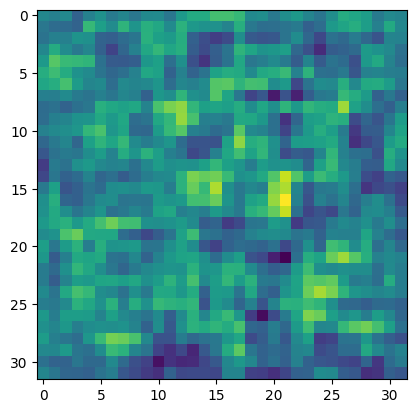

In [23]:
generator = create_generator()
noise = tensorflow.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

Our discriminator also appears to be able to make classifications, which is good news for us. To interpret its output, note that when the discriminator outputs negative values, it is classifying the image as a fake image and when it outputs positive values, it is classifying the image as a real image. With that in mind, it seems like the discriminator is already ahead of the generator as it has already made an accurate prediction from the generator’s image, but of course we are still going to go through the training process.

In [24]:
discriminator = create_discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00166478]], shape=(1, 1), dtype=float32)


##Training the GAN
In this part of the tutorial, we are going to showcase the training process that we used to train our GAN. This part of the tutorial is largely based on the Tensorflow DCGAN tutorial, and so if you would like to get a better understanding of how things work, you can find the tutorial [here](https://www.tensorflow.org/tutorials/generative/dcgan).

The loss function that we would be using is Binary Cross Entropy function and this is because there are only two classes of images in the context of our project: real images and fake images. This loss would be used in addition to more other criteria to define our discriminator’s loss function and our generator’s loss function.

In [25]:
#defining the loss function
cross_entropy = tensorflow.keras.losses.BinaryCrossentropy(from_logits=True)

The discriminator loss determines how well the discriminator is able to distinguish real images from fake images by comparing the discriminator’s predictions on real images to an array of 1s and comparing the discriminator’s predictions on fake images to an array of 0s.

In [26]:
#making the discriminator loss: define real_output and fake_output
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

The generator’s loss follows a similar approach as the discriminator’s loss but in this case, we compare the discriminator’s classifications of the fake images to an array of 1s. This is done because if the discriminator classifies most aspect of the fake images as 1s, thus classifying them as real, then the generator has done a reasonably good job in convincing the discriminator that it generated a real image.

In [27]:
#making the generator loss: define fake_output
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The last aspect of the models that we would be defining is the optimizer for each model. For our purposes, we would be using the Adam optimizer and both the generator and discriminator will have learning rates of 0.0001.

In [28]:
#defining the optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Here we define the training parameters which are the epochs, number of examples to be displayed by our generator after each epoch, and the seed which would serve as our noise distribution which we would use to visualize the progress of our generator. Additionally, we define the losses array, which would keep track of the losses of both the discriminator and the generator.

In [29]:
#training parameters
EPOCHS = 500
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, latent_dim])
losses = []

###Training Loop
The training loop is as follows: the generator receives a random seed as input which is then used to produce an image. Next, the discriminator is used to classify real images (drawn from the training set) and fakes images (produced by the generator). Afterwards, the loss is calculated for each of these models, and the gradients are used to update the generator and discriminator. In the midst of this training loop, we also used the generate_and_save_images function to track the progress our generator in real time as we use it to generate and output images after every epoch.
A checkpoint directory was also used during the training process but since we trained our model in a different notebook, the code for the checkpoints would not be included in this writeup.


In [30]:
def train_step(images):
    #define the noise distribution
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      #generate an image
      generated_images = generator(noise, training=True)

      #get the discriminators classifications
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      #calculate the loss of the functions 
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
  
      losses.append((disc_loss,gen_loss))
    #use the gradients to update the generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [31]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [32]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images to keep track of the generator's progress
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

##Post Training Results and Analysis

After training our model, this is what our losses looked like. From the plot, we can see that the discriminator had a lower loss than the generator at the initial training stages but towards the end of the training, both models appear to have similar loses.

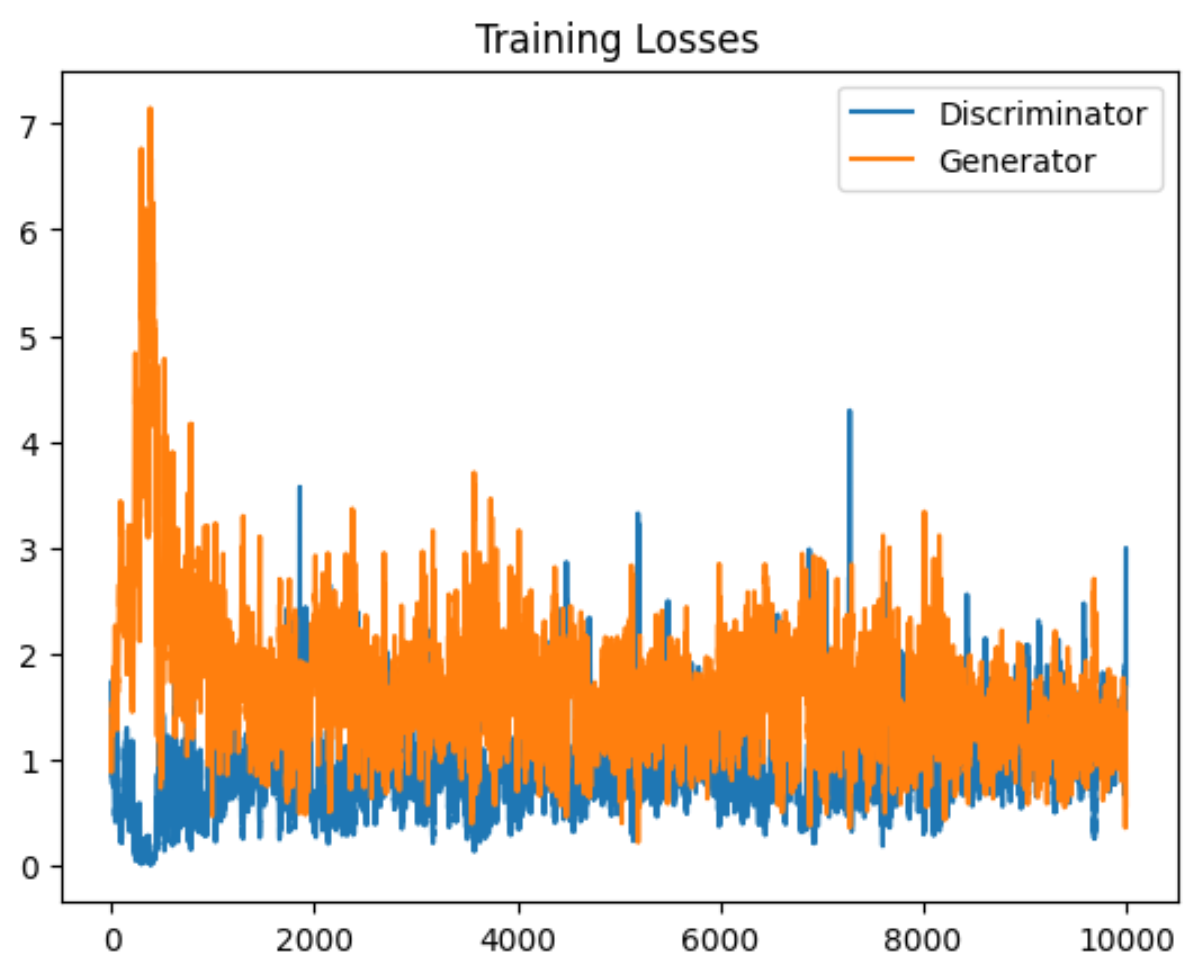

In [35]:
display.Image('Final Project- Training Losses 3.png')

###Generator's Predictions


As aforementioned, the generator was trained in a separate notebook and so to see its predictions, we will have to load the model first from the save file and then afterwards we can generate some images with our generator.

In [36]:
generator = tf.keras.saving.load_model("generator_model (1).keras")

The code cell below is used to generate some images from a random distribution which would serve as noise and the input to our generator. From the output, we can see that our generator did not learn how to perfectly generate cat images but we can also see signs that its aim is to generate such images. The ineffectiveness of the model to create clear cat images may be result of a variety of factors, including training time and the resolution of the training images. It is also important to keep in mind that GANs can be very tricky and difficult to train, especially due to the noise that is used to train the generator and the fact that the discrimininator can learn at a quicker rate than the generator. These are definitely areas for us to further look into but as of right now we can appreciate the progress we have made so far.

2/2 [==============================] - 0s 50ms/step


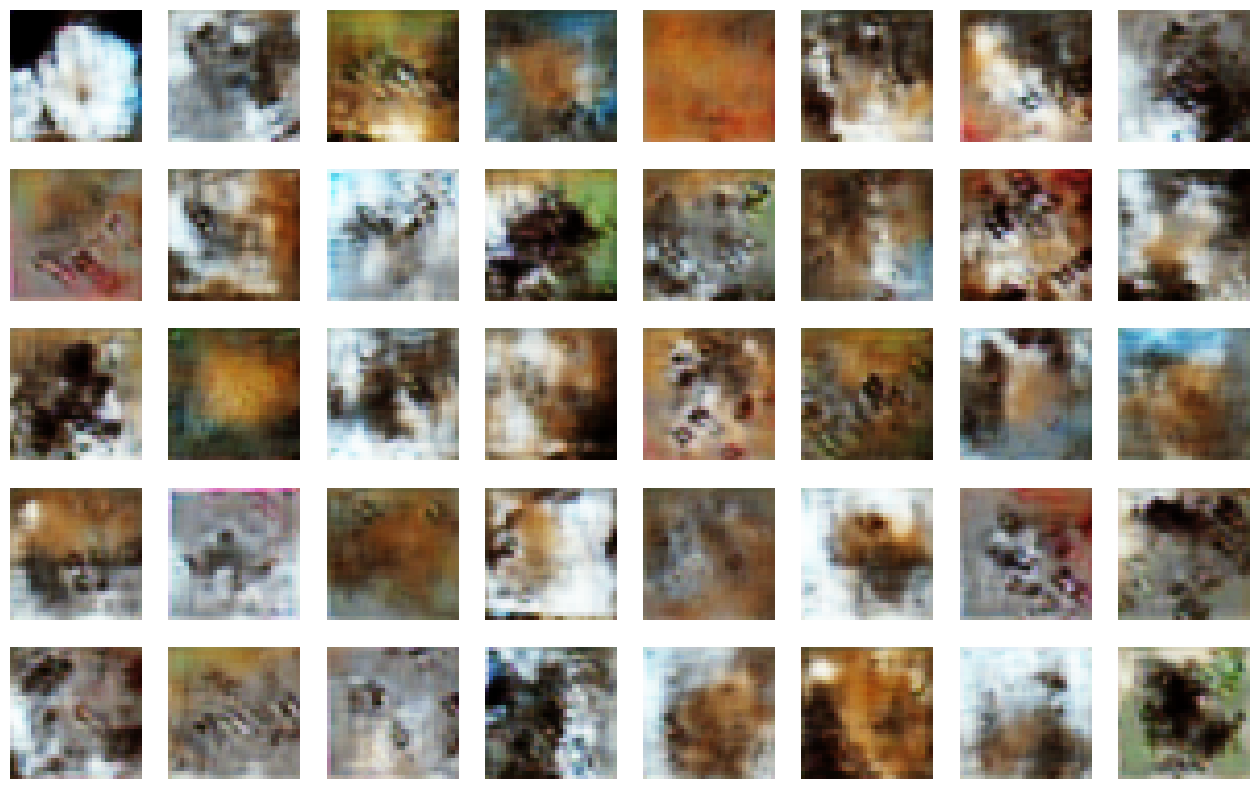

In [37]:
latent_dim = 100
noise = np.random.normal(size=(40, latent_dim))
generated_images = generator.predict(noise)
generated_images = (generated_images + 1) * 127.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, img in enumerate(generated_images):
        ax[i//8, i%8].imshow((img).astype(np.uint8))
        ax[i//8, i%8].axis('off')
        
plt.show()

#Testing the CNN with the GAN
Now that we have trained a generator, we can use it to further test our CNN. The structure for these tests is as follows: generate a variety of images -> make a classification about these images using the CNN -> determine how many times the CNN rightfully classified our image as fake. This is a very straightforward approach but is still effective in testing the efficacy of our model since this is how we expect our model to be used in real-world scenarios.

The code cell below shows us what our CNN's predictions look like. The CNN outputs two columns: the first column represents the CNN's verdict of the image being a real image and the second column represents the CNN's verdict of the image being a fake image. If any of the columns are negative, then it means that the CNN's classification is that the image does not belong to that class. A more intuitive way to view the CNN's classifications would have been to use a Softmax layer to show the probability outcomes but since that is not a part of our CNN's original architecture, we will be making a separate function that simulates the Softmax function and then we will use the function to represent the CNN's output as probabilities.

In [41]:
noise2 = np.random.normal(size=(10, latent_dim))
gen_images = generator.predict(noise2)
model_output = initial_model(gen_images)
print(model_output)

1/1 [==============================] - 0s 72ms/step
tf.Tensor(
[[-4.967404   9.418438 ]
 [-5.1962295  9.777582 ]
 [-5.036507   9.532894 ]
 [-5.1110015  9.673866 ]
 [-5.0485015  9.532667 ]
 [-5.1451726  9.690687 ]
 [-5.084962   9.587563 ]
 [-5.086588   9.648725 ]
 [-5.071779   9.60792  ]
 [-5.055473   9.566683 ]], shape=(10, 2), dtype=float32)


Below we have defined a basic softmax function for two classes, since we are only focused on the real class and fake class. The values parameter represents a single output from our CNN and so it has two columns, which we access and use to create our softmax function.

In [39]:
def softmax(values):
  #getting the output from the final Dense layer
  pred_1 = values[0]
  pred_2 = values[1]

  #calculating the denominator of the formula
  denom = np.exp(pred_1) + np.exp(pred_2)

  #returning the Softmax output for each prediction in an array with two columns
  return [np.exp(pred_1)/denom, np.exp(pred_2)/denom]

After passing the model's outputs through the softmax function we created above, we see that we get the expected results. 

In [42]:
for values in model_output:
  print(softmax(values))

[5.6533776e-07, 0.99999946]
[3.140191e-07, 0.99999964]
[4.7053206e-07, 0.9999995]
[3.7932668e-07, 0.99999964]
[4.650276e-07, 0.9999995]
[3.604689e-07, 0.99999964]
[4.244274e-07, 0.9999996]
[3.9859785e-07, 0.99999964]
[4.213934e-07, 0.9999996]
[4.463528e-07, 0.9999995]


Now, we go through our testing loop. First, we create the noise distribution and use it as the input to our generator to create images. Next, we classify the generator's images using our CNN. Lastly, we check the probability of that the fake images were classified as fake and keep track of the amount of the correctly classified fake images.

In [44]:
#defining the noise distribution
noise3 = np.random.normal(size=(1000, latent_dim))
#generating images
gen_images = generator.predict(noise3)
#classifying the predictions using the CNN
model_output = initial_model(gen_images)

#counter to keep track of correct classification by the CNN
correct_count = 0

#looping through each value
for values in model_output:
  #calculating the softmax output for each classification
  softmax_output = softmax(values)
  #incrementing correct_count if the probability of the image being fake is classified as greater than 0.5
  if softmax_output[1] > 0.5:
    correct_count += 1

32/32 [==============================] - 8s 240ms/step


Based on the output of the below cell, we can see that our CNN performed exceptionally well as it was able to predict  100% of the images correctly. Although this is a good performance, it is important to keep in mind that our GAN is a very basic model in comparison to the more complex generative models available and so our CNN would have a much easier time predicting the images. We can, however, still take it as a positive that our model performed this well.

In [46]:
print('Percentage Classified Correctly: ', (correct_count/1000) * 100, '%')

Percentage Classified Correctly:  100.0 %


#Conclusion and Future Work
Although our CNN model appears to be performing well, there are still some areas that we would have to address to improve our model and the GAN that we created.
Firstly, it will be important for us to spend more time training the GAN so that it can generate clearer and higher resolution images, and also so that the images better fit the distribution that the GAN was trained, which in our case is the distribution of cat images. 
Secondly, we may need to use a different generation model, like a transformer or diffusion model, to further test our CNN since most AI generators are more complex than our current GAN.
Lastly, to increase the versatility of our model, we will need to train our  CNN on different image styles since AI image generators do not strictly produce realistic images, like the ones we trained our model on.

These future contributions would definitely improve the ability of both our models and it would be exciting to see the capabilities of our models once we have implented these changes.
